In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

# Vector of cities
CITIES = ["Alicante","Barcelona","Bilbao","Cáceres","Cádiz","Córdoba",
          "Coruña","Girona","Huelva","León","Madrid","Murcia","Oviedo",
          "Pamplona","Donostia","Sevilla","Tarragona","Toledo","Valencia",
          "Zaragoza"
]

# Matrix of distances
M = [
  [0,515,817,675,688,525,1031,615,703,855,422,75,873,673,766,609,417,411,166,498],
  [515,0,620,918,1284,908,1118,100,1140,784,621,590,902,437,529,1046,98,692,349,296],
  [817,620,0,605,1058,795,644,720,939,359,395,796,304,159,119,993,555,466,633,324],
  [675,918,605,0,369,319,683,1018,323,407,297,654,525,650,679,264,831,264,636,622],
  [688,1284,1058,369,0,263,1072,1384,219,796,663,613,914,1070,1132,125,1059,583,808,988],
  [525,908,795,319,263,0,995,1008,232,733,400,444,851,807,869,138,796,320,545,725],
  [1031,1118,644,683,1072,995,0,1218,1006,334,609,1010,340,738,763,947,1064,675,961,833],
  [615,100,720,1018,1384,1008,1218,0,1240,884,721,690,1002,537,629,1146,198,792,449,396],
  [703,1140,939,323,219,232,1006,1240,0,730,632,628,821,1039,1101,94,1029,552,791,957],
  [855,784,359,407,796,733,334,884,730,0,333,734,118,404,433,671,719,392,685,488],
  [422,621,395,297,663,400,609,721,632,333,0,401,451,407,469,538,534,71,352,325],
  [75,590,796,654,613,444,1010,690,628,734,401,0,852,714,807,534,492,390,241,539],
  [873,902,304,525,914,851,340,1002,821,118,451,852,0,463,423,789,835,510,803,604],
  [673,437,159,650,1070,807,738,537,1039,404,407,714,463,0,92,945,372,478,501,175],
  [766,529,119,679,1132,869,763,629,1101,433,469,807,423,92,0,1007,464,540,594,268],
  [609,1046,993,264,125,138,947,1146,94,671,538,534,789,945,1007,0,949,458,697,863],
  [417,98,555,831,1059,796,1064,198,1029,719,534,492,835,372,464,949,0,605,251,231],
  [411,692,466,264,583,320,675,792,552,392,71,390,510,478,540,458,605,0,372,396],
  [166,349,633,636,808,545,961,449,791,685,352,241,803,501,594,697,251,372,0,326],
  [498,296,324,622,988,725,833,396,957,488,325,539,604,175,268,863,231,396,326,0]
]

#city_distance_map = {city: M[index] for index, city in enumerate(CITIES)}
#for city, distances in city_distance_map.items():
    #print(f"{city}: {distances}")

POPULATION_SIZE = 100
NUMBER_OF_CITIES = len(CITIES)
POSITION_ORIGIN_DESTINATION = 13
NUMBER_OF_INDIVIDUALS_TOURNAMENT = 5
NUMBER_OF_PARENTS = POPULATION_SIZE

def getIndividual():
  individual = random.sample(range(0, NUMBER_OF_CITIES), NUMBER_OF_CITIES)
  return individual

print(getIndividual())

[9, 16, 7, 18, 19, 6, 14, 13, 0, 4, 17, 3, 2, 12, 15, 5, 11, 1, 10, 8]


**FITNESS FUNCTION**

In [2]:
def fitness(population):
    fitness_scores = np.zeros(len(population))

    for i in range(len(population)):
      for j in range(NUMBER_OF_CITIES - 1):
        fitness_scores[i] += M[population[i][j]] [population[i][j+1]]
      fitness_scores[i] += M[population[i][0]] [population[i][NUMBER_OF_CITIES - 1]]

    return fitness_scores

**INITIAL POPULATION**

In [3]:
def getPopulation():
  population = []
  for i in range(POPULATION_SIZE):
    population.append(getIndividual())
  return population

**PARENT SELECTION**

In [4]:
def getNormalizedProbabilitiesForChoosingTheParent(population):
    inverted_fitness_scores = 1 / fitness(population)

    goldbergThresolds = np.mean(inverted_fitness_scores) - np.std(inverted_fitness_scores) * 2
    goldbergProbabilities = np.maximum(inverted_fitness_scores - goldbergThresolds, 0)

    normalizedProbabilities = goldbergProbabilities / (np.sum(goldbergProbabilities) + 1e-6)

    return normalizedProbabilities

def progenitorSelectionRouletteMethod(population): #ROULETTE METHOD
  normalizedProbabilities = getNormalizedProbabilitiesForChoosingTheParent(population)

  sumaNormalizedProbabilities = 0
  p = random.random()

  cumulativeProbabilities = np.cumsum(normalizedProbabilities)
  index = np.searchsorted(cumulativeProbabilities, p)
  return min(index, len(population) - 1)

def progenitorSelectionTournamentMethod(population, parentSelectionMethod): #TOURNAMENT METHOD
  if parentSelectionMethod == "Tournament with replacement":
    individualsTournamentIndexes = random.choices(range(POPULATION_SIZE), k=NUMBER_OF_INDIVIDUALS_TOURNAMENT)
  else:
    individualsTournamentIndexes = random.sample(range(POPULATION_SIZE), k=NUMBER_OF_INDIVIDUALS_TOURNAMENT)

  tournament_fitness_scores = fitness([population[i] for i in individualsTournamentIndexes])
  winnerIndexFitness = np.argmin(tournament_fitness_scores)

  return individualsTournamentIndexes[winnerIndexFitness]

**CROSS OVER**

In [5]:
def getStartAndFinalIndex(sizeChromosome):
    startIndex = random.randint(0, sizeChromosome - 1)
    endIndex = random.randint(0, sizeChromosome - 1)

    return min(startIndex, endIndex), max(startIndex, endIndex)

def fillRemainingPositionsWithOtherChromosome(child, chromosome, defaultValue):
    sizeChromosome = len(child)
    for i in range(sizeChromosome):
      if child[i] == defaultValue:
        child[i] = chromosome[i]

    return child

def mapNonCrossoverRegion(child, parent, other_parent, startIndex, endIndex):
    indexMapOtherParent = {value: index for index, value in enumerate(other_parent)}

    for i in range(startIndex, endIndex + 1):
      if other_parent[i] not in child:
        target_value = parent[i]
        isOutsideCrossOverRegion = False

        while not isOutsideCrossOverRegion:
          indexTargetValue = indexMapOtherParent[target_value]

          if indexTargetValue not in range(startIndex, endIndex + 1):
            child[indexTargetValue] = other_parent[i]
            isOutsideCrossOverRegion = True

          else:
            target_value = parent[indexTargetValue]

    return child

def partiallyMappedCrossOver(chromosome1, chromosome2, prob_cross): #Partially Mapped Cross Over (PMX)
  if random.random() <= prob_cross:
    sizeChromosome = len(chromosome1)
    startIndex, endIndex = getStartAndFinalIndex(sizeChromosome)
    startIndex = 3
    endIndex = 6
    defaultValue = -1
    child1 = [defaultValue] * sizeChromosome
    child2 = [defaultValue] * sizeChromosome

    child1[startIndex:endIndex + 1] = chromosome1[startIndex:endIndex + 1]
    child2[startIndex:endIndex + 1] = chromosome2[startIndex:endIndex + 1]

    child1WithCrossOverRegion = mapNonCrossoverRegion(child1, chromosome1, chromosome2, startIndex, endIndex)
    child2WithCrossOverRegion = mapNonCrossoverRegion(child2, chromosome2, chromosome1, startIndex, endIndex)

    child1 = fillRemainingPositionsWithOtherChromosome(child1WithCrossOverRegion, chromosome2, defaultValue)
    child2 = fillRemainingPositionsWithOtherChromosome(child2WithCrossOverRegion, chromosome1, defaultValue)

    return child1, child2
  else:
    return chromosome1, chromosome2

def fillRemainingPositionsWithOtherParent(child, otherParent, endIndex, defaultValue):
    sizeChromosome = len(child)
    indexParent = (endIndex + 1) % sizeChromosome
    indexChild = (endIndex + 1) % sizeChromosome

    fillCount = child.count(defaultValue)

    while fillCount > 0:
        if otherParent[indexParent] not in child:
            child[indexChild] = otherParent[indexParent]
            indexChild = (indexChild + 1) % sizeChromosome
            fillCount -= 1
        indexParent = (indexParent + 1) % sizeChromosome

    return child

def orderBassedCrossOver(chromosome1, chromosome2, prob_cross): #Order Bassed Cross Over
  if random.random() <= prob_cross:
    sizeChromosome = len(chromosome1)
    startIndex, endIndex = getStartAndFinalIndex(sizeChromosome)

    defaultValue = -1
    child1 = [defaultValue] * sizeChromosome
    child2 = [defaultValue] * sizeChromosome

    child1[startIndex:endIndex + 1] = chromosome1[startIndex:endIndex + 1]
    child2[startIndex:endIndex + 1] = chromosome2[startIndex:endIndex + 1]

    child1 = fillRemainingPositionsWithOtherParent(child1, chromosome2, endIndex, defaultValue)
    child2 = fillRemainingPositionsWithOtherParent(child2, chromosome1, endIndex, defaultValue)

    return child1, child2
  else:

    return chromosome1, chromosome2

**MUTATION**

In [6]:
def checkIfIndexesAreEqual(startIndex, endIndex, sizeChromosome):
  while startIndex == endIndex:
    endIndex = random.randint(0, sizeChromosome - 1)
  return endIndex

def defineIndex1LowerThanIndex2(startIndex, endIndex):
  return min(startIndex, endIndex), max(startIndex, endIndex)

def exchangeMutation(chromosome, prob_mut):
    mutated_chromosome = chromosome.copy()

    if random.random() < prob_mut:
      sizeChromosome = len(chromosome)

      startIndex = random.randint(0, sizeChromosome - 1)
      endIndex = random.randint(0, sizeChromosome - 1)

      endIndex = checkIfIndexesAreEqual(startIndex, endIndex, sizeChromosome)

      aux = mutated_chromosome[startIndex]
      mutated_chromosome[startIndex] = mutated_chromosome[endIndex]
      mutated_chromosome[endIndex] = aux

    return mutated_chromosome

def insertionMutation(chromosome, prob_mut):
    mutated_chromosome = chromosome.copy()

    if random.random() < prob_mut:
      sizeChromosome = len(chromosome)

      startIndex = random.randint(0, sizeChromosome - 1)
      endIndex = random.randint(0, sizeChromosome - 1)

      endIndex = checkIfIndexesAreEqual(startIndex, endIndex, sizeChromosome)
      startIndex, endIndex = defineIndex1LowerThanIndex2(startIndex, endIndex)

      while startIndex != endIndex - 1:
        aux = mutated_chromosome[endIndex - 1]
        mutated_chromosome[endIndex - 1] = mutated_chromosome[endIndex]
        mutated_chromosome[endIndex] = aux
        endIndex -= 1

    return mutated_chromosome

def shakeMutation(chromosome, prob_mut):
    mutated_chromosome = chromosome.copy()

    if random.random() < prob_mut:
      sizeChromosome = len(chromosome)

      startIndex = random.randint(0, sizeChromosome - 1)
      endIndex = random.randint(0, sizeChromosome - 1)

      endIndex = checkIfIndexesAreEqual(startIndex, endIndex, sizeChromosome)
      startIndex, endIndex = defineIndex1LowerThanIndex2(startIndex, endIndex)

      partToShuffleChromosome = chromosome[startIndex:endIndex + 1]
      random.shuffle(partToShuffleChromosome)

      mutated_chromosome[startIndex:endIndex + 1] = partToShuffleChromosome

    return mutated_chromosome

def inversionMutation(chromosome, prob_mut):
    mutated_chromosome = chromosome.copy()

    if random.random() < prob_mut:
      sizeChromosome = len(chromosome)

      startIndex = random.randint(1, sizeChromosome - 2)
      endIndex = random.randint(1, sizeChromosome - 2)

      endIndex = checkIfIndexesAreEqual(startIndex, endIndex, sizeChromosome)
      startIndex, endIndex = defineIndex1LowerThanIndex2(startIndex, endIndex)

      partToInvertChromosome = chromosome[startIndex:endIndex + 1]
      partInversedChromosome = partToInvertChromosome[::-1]

      mutated_chromosome[startIndex:endIndex + 1] = partInversedChromosome

    return mutated_chromosome


mutate_chromosome = exchangeMutation([1,2,3,4,5,6], 1) #do always mutation (p=1)
print("Exchange Mutation: ", mutate_chromosome)

mutate_chromosome = insertionMutation([1,2,3,4,5,6], 1)
print("Insertion Mutation: ", mutate_chromosome)

mutate_chromosome = shakeMutation([1,2,3,4,5,6], 1)
print("Shake Mutation: ", mutate_chromosome)

mutate_chromosome = inversionMutation([1,2,3,4,5,6], 1)
print("Inversion Mutation: ", mutate_chromosome)

Exchange Mutation:  [1, 3, 2, 4, 5, 6]
Insertion Mutation:  [1, 2, 3, 4, 6, 5]
Shake Mutation:  [1, 2, 3, 6, 5, 4]
Inversion Mutation:  [1, 5, 4, 3, 2, 6]


**SURVIVAL SELECTION**

In [7]:
def survivorSelection(population, new_individuals): #FITNESS-BASED REPLACEMENT
    combined_population = population + new_individuals

    fitness_scores = fitness(combined_population)

    population_with_fitness = list(zip(combined_population, fitness_scores))
    population_with_fitness.sort(key=lambda individual: individual[1], reverse=False)

    new_population = [individual[0] for individual in population_with_fitness[:len(population)]]

    return new_population

**GENETIC ALGORITHM**

In [15]:
def geneticAlgorithm(parentSelectionMethod):
    num_iterations = 100
    prob_cross = 0.95
    prob_mut = 0.1

    bestIndividualPerGeneration = []
    bestFitnessSolutionAlgorithm = float('inf')
    bestIndividualSolutionAlgorithm = None

    if parentSelectionMethod == "Roulette":
        selection_function = progenitorSelectionRouletteMethod
    else:
        selection_function = lambda pop: progenitorSelectionTournamentMethod(pop, parentSelectionMethod)

    print("Parent selection method: ", parentSelectionMethod)

    population = getPopulation()

    for iteration in range(num_iterations):
        # Parent selection
        parents = []
        for i in range(NUMBER_OF_PARENTS):
            winnerIndex = selection_function(population)
            parents.append(population[winnerIndex])

        # Crossover and mutation
        new_population = []
        for i in range(0, NUMBER_OF_PARENTS, 2):
          if i + 1 < NUMBER_OF_PARENTS:
              #PMX
              descendant1, descendant2 = partiallyMappedCrossOver(parents[i], parents[i+1], prob_cross)
              #ORDER-BASSED
              #descendant1, descendant2 = orderBassedCrossOver(parents[i], parents[i+1], prob_cross)

              new_population.append(exchangeMutation(descendant1, prob_mut))
              new_population.append(exchangeMutation(descendant2, prob_mut))
              #NO MUTATION:
              #new_population.append(descendant1)
              #new_population.append(descendant2)

        # Survivor selection
        population = survivorSelection(population, new_population)

        # Fitness evaluation
        fitness_scores = fitness(population)
        bestFitnessGeneration = min(fitness_scores)

        if bestFitnessGeneration < bestFitnessSolutionAlgorithm:
            bestFitnessSolutionAlgorithm = bestFitnessGeneration
            bestIndividualSolutionAlgorithm = population[np.argmin(fitness_scores)]

        bestIndividualPerGeneration.append(bestFitnessGeneration)

        if bestFitnessGeneration == 4367: #BEST SOLUTION WITH ALL CITIES
          break
    print("Fitness ", fitness_scores)

    plt.plot(bestIndividualPerGeneration)
    plt.xlabel('Iteración')
    plt.ylabel('Menor Fitness')
    plt.title('Evolución del menor fitness por iteración')
    plt.show()

    return bestIndividualSolutionAlgorithm, bestFitnessSolutionAlgorithm

**MAIN LOOP**

Parent selection method:  Roulette
Fitness  [5648. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944.
 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944.
 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944.
 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944.
 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944.
 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944.
 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944.
 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944. 5944.
 5944. 5944. 5944. 5944.]


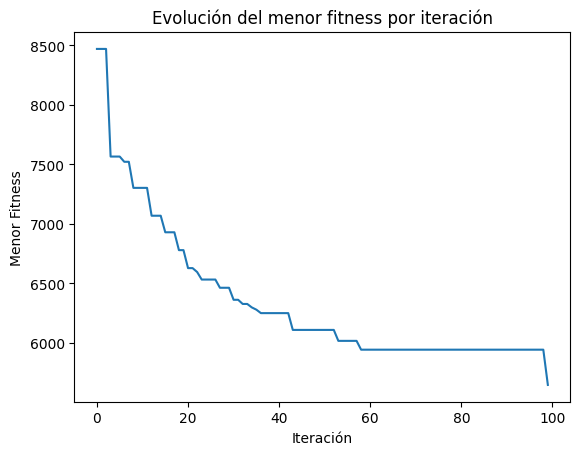

Solución de la iteración 1: [2, 3, 8, 4, 15, 5, 17, 6, 12, 9, 19, 7, 1, 16, 11, 0, 18, 10, 13, 14], Fitness: 5648.0
Parent selection method:  Roulette
Fitness  [5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046.
 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046.
 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046.
 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046.
 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046.
 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046.
 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046.
 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046. 5046.
 5046. 5046. 5046. 5046.]


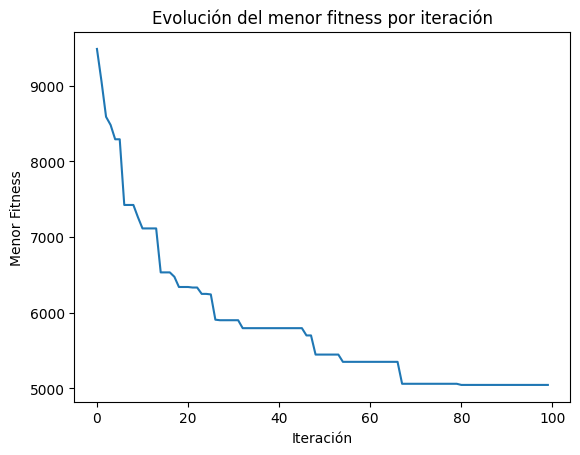

Solución de la iteración 2: [4, 15, 8, 3, 9, 6, 12, 2, 14, 13, 19, 10, 17, 11, 0, 7, 1, 16, 18, 5], Fitness: 5046.0
Parent selection method:  Roulette
Fitness  [4367. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421.
 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421.
 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421.
 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421.
 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421.
 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421.
 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421.
 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421. 4421.
 4421. 4421. 4421. 4421.]


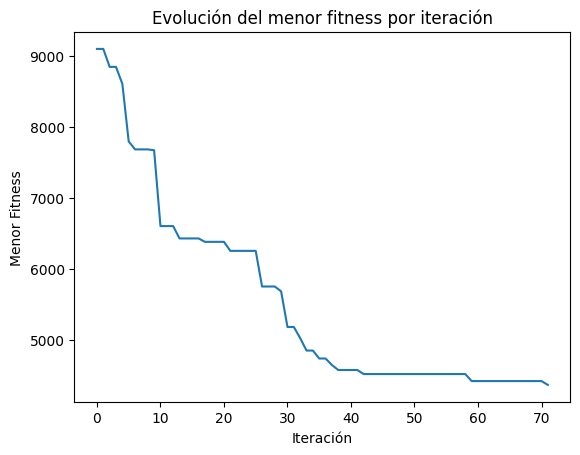

Solución de la iteración 3: [17, 10, 9, 6, 12, 2, 14, 13, 19, 7, 1, 16, 18, 0, 11, 5, 4, 15, 8, 3], Fitness: 4367.0
Parent selection method:  Tournament with replacement
Fitness  [4367. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382.
 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382.
 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382.
 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382.
 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382.
 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382.
 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382.
 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382. 4382.
 4382. 4382. 4382. 4382.]


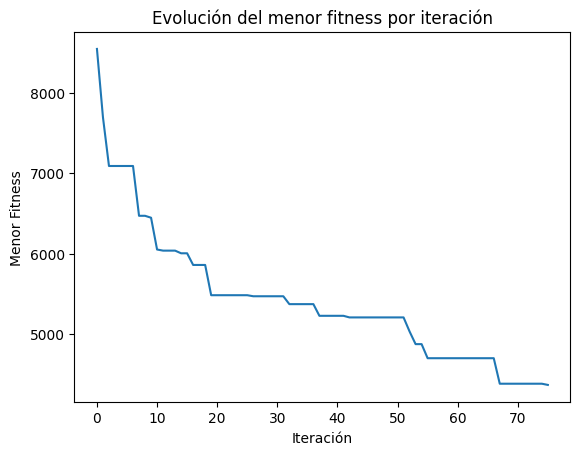

Solución de la iteración 1: [10, 9, 6, 12, 2, 14, 13, 19, 1, 7, 16, 18, 0, 11, 5, 4, 15, 8, 3, 17], Fitness: 4367.0
Parent selection method:  Tournament with replacement
Fitness  [5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296.
 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296.
 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296.
 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296.
 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296.
 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296.
 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296.
 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296. 5296.
 5296. 5296. 5296. 5296.]


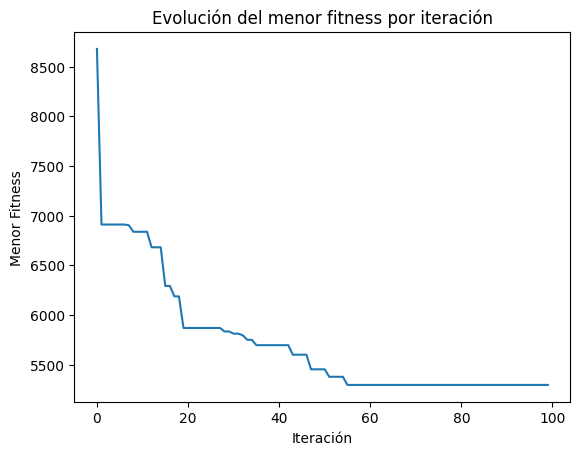

Solución de la iteración 2: [7, 19, 3, 5, 15, 4, 8, 9, 6, 12, 2, 14, 13, 10, 17, 11, 0, 18, 16, 1], Fitness: 5296.0
Parent selection method:  Tournament with replacement
Fitness  [5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250.
 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250.
 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250.
 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250.
 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250.
 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250.
 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250.
 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250. 5250.
 5250. 5250. 5250. 5250.]


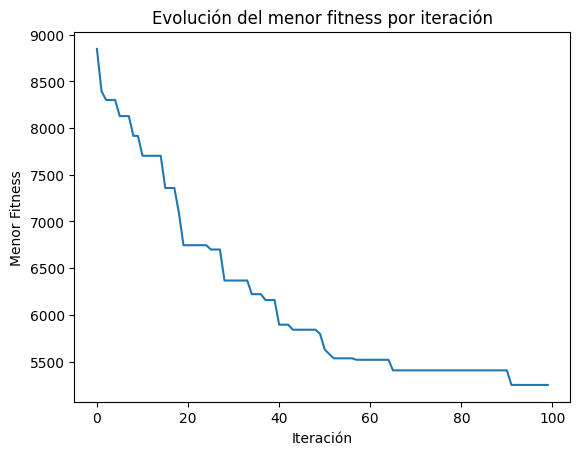

Solución de la iteración 3: [4, 15, 8, 5, 11, 0, 18, 10, 13, 19, 16, 7, 1, 14, 2, 12, 6, 9, 17, 3], Fitness: 5250.0
Parent selection method:  Tournament without replacement
Fitness  [5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180.
 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180.
 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180.
 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180.
 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180.
 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180.
 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180.
 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180. 5180.
 5180. 5180. 5180. 5180.]


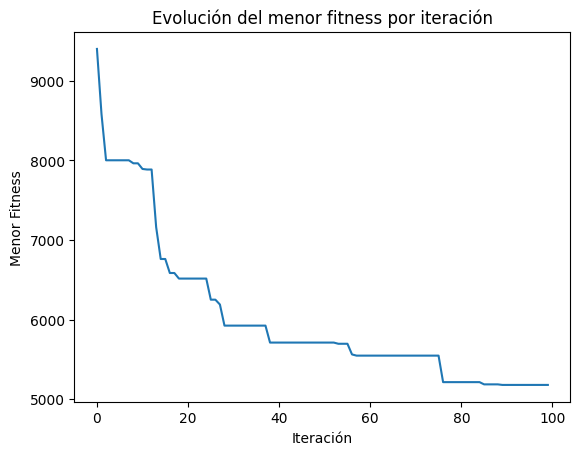

Solución de la iteración 1: [16, 18, 0, 11, 13, 14, 2, 12, 6, 9, 8, 4, 15, 5, 3, 17, 10, 19, 1, 7], Fitness: 5180.0
Parent selection method:  Tournament without replacement
Fitness  [5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654.
 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654.
 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654.
 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654.
 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654.
 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654.
 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654.
 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654. 5654.
 5654. 5654. 5654. 5654.]


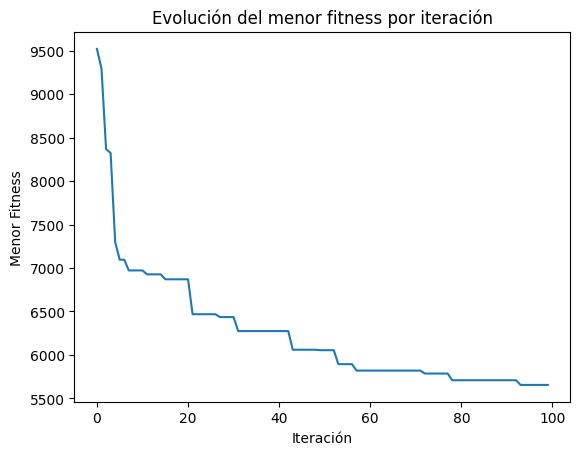

Solución de la iteración 2: [0, 11, 17, 10, 9, 6, 12, 2, 14, 3, 8, 4, 15, 5, 18, 16, 7, 1, 13, 19], Fitness: 5654.0
Parent selection method:  Tournament without replacement
Fitness  [6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227.
 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227.
 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227.
 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227.
 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227.
 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227.
 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227.
 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227. 6227.
 6227. 6227. 6227. 6227.]


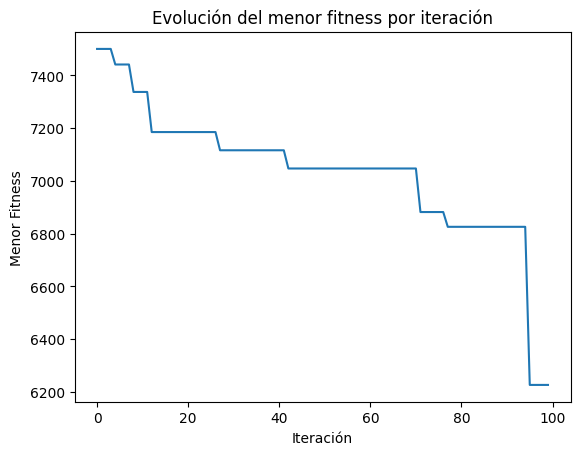

Solución de la iteración 3: [15, 4, 11, 0, 18, 16, 19, 2, 14, 13, 1, 7, 5, 8, 3, 17, 10, 12, 6, 9], Fitness: 6227.0
Mejor solución global encontrada:
['Pamplona', 'Zaragoza', 'Girona', 'Barcelona', 'Tarragona', 'Valencia', 'Alicante', 'Murcia', 'Córdoba', 'Cádiz', 'Sevilla', 'Huelva', 'Cáceres', 'Toledo', 'Madrid', 'León', 'Coruña', 'Oviedo', 'Bilbao', 'Donostia', 'Pamplona']
Fitness global: 4367.0
Tiempo de ejecución del algoritmo: 40.063210010528564


In [25]:
POPULATION_SIZE = 100
NUMBER_OF_CITIES = len(CITIES)
POSITION_ORIGIN_DESTINATION = 13
NUMBER_OF_INDIVIDUALS_TOURNAMENT = 5
NUMBER_OF_PARENTS = POPULATION_SIZE
NUMBER_OF_EXECUTIONS = 3

fitness_history = []
best_solution_overall = None
best_fitness_overall = float('inf')

parentSelectionMethods = ["Roulette", "Tournament with replacement", "Tournament without replacement"]

ini_time = time.time()
for parentSelectionMethod in parentSelectionMethods:
  for i in range(NUMBER_OF_EXECUTIONS):
      #ALGORITHM FUNCTION
      bestIndividualSolutionAlgorithm, bestFitnessSolutionAlgorithm = geneticAlgorithm(parentSelectionMethod)
      print(f"Solución de la iteración {i+1}: {bestIndividualSolutionAlgorithm}, Fitness: {bestFitnessSolutionAlgorithm}")

      #INDEXES TO NAMES
      solution_cities = [CITIES[index] for index in bestIndividualSolutionAlgorithm]

      origin_index = bestIndividualSolutionAlgorithm.index(POSITION_ORIGIN_DESTINATION)
      reordered_solution = bestIndividualSolutionAlgorithm[origin_index:] + bestIndividualSolutionAlgorithm[:origin_index] + [POSITION_ORIGIN_DESTINATION]
      solution_cities = [CITIES[index] for index in reordered_solution]

      #CHANGE FITNESS IF ITS MINOR
      if bestFitnessSolutionAlgorithm < best_fitness_overall:
          best_fitness_overall = bestFitnessSolutionAlgorithm
          best_solution_overall = solution_cities

fin_time = time.time()

#SHOW RESULTS
if best_solution_overall:
    print("Mejor solución global encontrada:")
    print(best_solution_overall)  # best_solution_overall ya contiene nombres de ciudades
    print("Fitness global:", best_fitness_overall)
    print("Tiempo de ejecución del algoritmo:", fin_time - ini_time)

